# <center>Toxic Comment Detection</center>

**The goal:** precision > 0.9 and recall -> max

## Imports

In [79]:
import pandas as pd
import numpy as np
import joblib
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from matplotlib import pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading Data

In [2]:
!wget https://raw.githubusercontent.com/julianzim/toxic_comment_detection/main/labeled.csv

--2023-11-03 12:58:07--  https://raw.githubusercontent.com/julianzim/toxic_comment_detection/main/labeled.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4669913 (4.5M) [text/plain]
Saving to: ‘labeled.csv’

labeled.csv         100%[===================>]   4.45M  --.-KB/s    in 0.06s   

2023-11-03 12:58:08 (71.8 MB/s) - ‘labeled.csv’ saved [4669913/4669913]



In [9]:
df = pd.read_csv('/content/labeled.csv', sep=',')
df['toxic'] = df['toxic'].apply(int)

___

## Data processing

In [4]:
df.shape

(14412, 2)

In [5]:
df['toxic'].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [6]:
df.query('toxic == 1')['comment']

0                     Верблюдов-то за что? Дебилы, бл...\n
1        Хохлы, это отдушина затюканого россиянина, мол...
2                                Собаке - собачья смерть\n
3        Страницу обнови, дебил. Это тоже не оскорблени...
4        тебя не убедил 6-страничный пдф в том, что Скр...
                               ...                        
14404    ЖЕНЩИНА это ВЕНЕЦ ТВОРЕНИЯ, помните это ваньки...
14405    Сейчас все авиакомпании мира вместе со специал...
14407    Вонючий совковый скот прибежал и ноет. А вот и...
14408    А кого любить? Гоблина тупорылого что-ли? Или ...
14410    КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...
Name: comment, Length: 4826, dtype: object

In [7]:
df.query('toxic == 0')['comment']

6        В шапке были ссылки на инфу по текущему фильму...
12       Почитайте посты у этого автора,может найдете ч...
17       Про графику было обидно) я так то проходил все...
28       https: pp.userapi.com c848520 v848520411 11627...
35       Возьмём как пример Россию, западноевропейские ...
                               ...                        
14392    ТАСС, 21 марта. Премьер-министр Новой Зеландии...
14399    65 А чего так мало? Вот у гражданина был рейти...
14406    Потому что запад прошел эту хуйню еще пару сот...
14409    Посмотрел Утомленных солнцем 2. И оказалось, ч...
14411    До сих пор пересматриваю его видео. Орамбо кст...
Name: comment, Length: 9586, dtype: object

In [112]:
stemmer = SnowballStemmer(language='russian')
russian_stop_words = stopwords.words('russian')

def tokenize_sentence(sentence: str, remove_stop_words=True):
    """Преобразует предложения в токены.
    По шагам:
    1) Токенизация - разбиение текста на отдельные слова и знаки пунктуации
    2) Удаляем знаки пунктуации
    3) Удаляем стоп-слова (часто используемые, не несущие смысловой нагрузки)
    4) Стемминг (stem - корень) - удаление окончаний и приведение к нижнему регистру
    """
    tokens = word_tokenize(sentence, language='russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [stemmer.stem(i) for i in tokens]
    return tokens

In [113]:
example = df.loc[1]['comment']
example

'Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.\n'

In [114]:
tokenize_sentence(example)

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

In [115]:
vectorizer = TfidfVectorizer(tokenizer=tokenize_sentence,
                             token_pattern=None)

In [116]:
%%time
features, labels = df['comment'], df['toxic']
features_vect = vectorizer.fit_transform(features)
x_train, x_test, y_train, y_test = train_test_split(features_vect,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=0)

CPU times: user 17 s, sys: 0 ns, total: 17 s
Wall time: 17 s


___

##Naive Bayes Multinomial baseline

In [15]:
%%time
nb_model = MultinomialNB()
nb_model.fit(x_train, y_train)

CPU times: user 7.83 ms, sys: 3.04 ms, total: 10.9 ms
Wall time: 10.6 ms


MultinomialNB()

In [16]:
print(classification_report(y_test, nb_model.predict(x_test), digits=4))

              precision    recall  f1-score   support

           0     0.7825    0.9906    0.8744      1918
           1     0.9604    0.4528    0.6155       965

    accuracy                         0.8106      2883
   macro avg     0.8715    0.7217    0.7449      2883
weighted avg     0.8421    0.8106    0.7877      2883



**This is the best decision for these task**

___

## Testing other baselines

In [ ]:
def models_report(models, x_train, x_test, y_train, y_test):
    report = pd.DataFrame()
    #сюда можно вставить разделение выборки
    for model in models:
        clf = models[model].fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        report.loc[model, 'Precision'] = precision_score(y_test, y_pred).round(4)
        report.loc[model, 'Recall'] = recall_score(y_test, y_pred).round(4)
        report.loc[model, 'F1-score'] = f1_score(y_test, y_pred).round(4)
        report.loc[model, 'ROC-AUC'] = roc_auc_score(y_test, y_pred).round(4)
    return report

In [ ]:
models = {'kNN': KNeighborsClassifier(),
          'LogisticRegression': LogisticRegression(),
          'SGDClassifier': SGDClassifier(loss='log_loss'),
          'SVC': SVC(),
          'XGBClassifier': XGBClassifier(),
          'DecisionTree': DecisionTreeClassifier()}

In [ ]:
%%time
models_report(models, x_train, x_test, y_train, y_test)

CPU times: user 1min 30s, sys: 1.46 s, total: 1min 32s
Wall time: 1min 15s


,Precision,Recall,F1-score,ROC-AUC
kNN,0.8192,0.5212,0.6371,0.7317
LogisticRegression,0.9160,0.5990,0.7243,0.7857
SGDClassifier,0.9183,0.5824,0.7127,0.7782
SVC,0.9123,0.6363,0.7497,0.8028
XGBClassifier,0.8891,0.4984,0.6388,0.7336
DecisionTree,0.6980,0.6010,0.6459,0.7351


___

## Parameters tuning

### kNN

In [ ]:
%%time
knn_grid = GridSearchCV(KNeighborsClassifier(),
                        param_grid={'n_neighbors': range(10, 21)},
                        verbose=0,
                        cv=3)
knn_grid.fit(x_train, y_train)

print(f'best params: {knn_grid.best_params_}')
print(f' best score: {knn_grid.best_score_}')
print(classification_report(y_test, knn_grid.predict(x_test), digits=4))

best params: {'n_neighbors': 13}
 best score: 0.8244427096886113
              precision    recall  f1-score   support

           0     0.8158    0.9536    0.8793      1918
           1     0.8612    0.5720    0.6874       965

    accuracy                         0.8259      2883
   macro avg     0.8385    0.7628    0.7834      2883
weighted avg     0.8310    0.8259    0.8151      2883

CPU times: user 9min 58s, sys: 1.05 s, total: 9min 59s
Wall time: 6min 23s


___

### Logistic Regression

In [46]:
%%time
lr_grid = GridSearchCV(LogisticRegression(max_iter=300),
                       param_grid={'C': np.logspace(-1, 2, 30)},
                       verbose=0,
                       cv=3)
lr_grid.fit(x_train, y_train)

print(f'best params: {lr_grid.best_params_}')
print(f' best score: {lr_grid.best_score_}')
print(classification_report(y_test, lr_grid.predict(x_test), digits=4))

best params: {'C': 23.95026619987486}
 best score: 0.8604388932257785
              precision    recall  f1-score   support

           0     0.8698    0.9400    0.9035      1918
           1     0.8580    0.7202    0.7831       965

    accuracy                         0.8665      2883
   macro avg     0.8639    0.8301    0.8433      2883
weighted avg     0.8658    0.8665    0.8632      2883

CPU times: user 1min 12s, sys: 1min 30s, total: 2min 42s
Wall time: 1min 58s


In [47]:
pr, rc, ths = precision_recall_curve(y_true=y_test,
                                     probas_pred=lr_grid.predict_proba(x_test)[:,1])

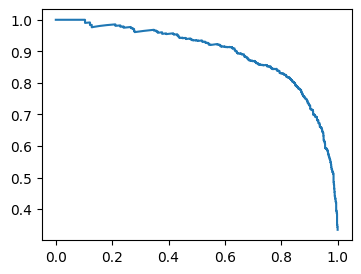

In [48]:
plt.figure(figsize=(4, 3))
plt.plot(rc, pr)

In [49]:
pr_index = np.where(pr > 0.9)[0][0]
threshold = ths[pr_index].round(4)
y_pred = lr_grid.predict_proba(x_test)[:,1] > threshold
print(f'Precision: {precision_score(y_test, y_pred).round(4)}')
print(f'Recall: {recall_score(y_test, y_pred).round(4)}')
print(f'Threshold: {threshold}')

Precision: 0.9007
Recall: 0.6394
Threshold: 0.6335


___

### SVM

In [ ]:
%%time
svc_grid = GridSearchCV(SVC(),
                        param_grid={'C': [0.9],
                                    'gamma': [0.09]
                                   },
                        verbose=0,
                        scoring='precision',
                        cv=2)
svc_grid.fit(x_train, y_train)

print(f'best params: {svc_grid.best_params_}')
print(f' best score: {svc_grid.best_score_}')
print(classification_report(y_test, svc_grid.predict(x_test), digits=4))

best params: {'C': 0.9, 'gamma': 0.09}
 best score: 0.9732548410231892
              precision    recall  f1-score   support

           0     0.7414    0.9927    0.8489      1918
           1     0.9556    0.3119    0.4703       965

    accuracy                         0.7648      2883
   macro avg     0.8485    0.6523    0.6596      2883
weighted avg     0.8131    0.7648    0.7222      2883

CPU times: user 36.5 s, sys: 122 ms, total: 36.6 s
Wall time: 36.6 s


___

### XGBoost

In [ ]:
%%time
trees = [1] + list(range(2, 15))
xgb_scoring = []
for tree in trees:
    xgb = XGBClassifier(n_estimators=tree)
    score = cross_val_score(xgb, x_train, y_train, scoring='precision', cv=3)
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)

CPU times: user 1min 3s, sys: 1.39 s, total: 1min 4s
Wall time: 35.9 s


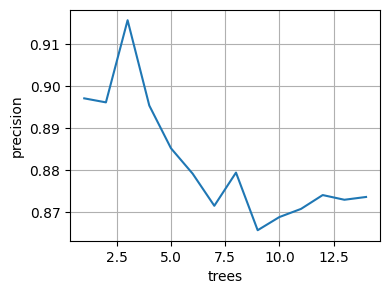

In [ ]:
plt.figure(figsize=[4,3])
plt.plot(trees, xgb_scoring.mean(axis=1), label='XGBoost')
plt.grid(True)
plt.xlabel('trees')
plt.ylabel('precision')
plt.show()

In [ ]:
trees = list(range(10, 110, 10))
scores = []
for tree in trees:
    xgb_grid = XGBClassifier(n_estimators=tree)
    xgb_grid.fit(x_train, y_train)
    prec = precision_score(y_test, xgb_grid.predict(x_test))
    rec = recall_score(y_test, xgb_grid.predict(x_test))
    if prec > 0.9:
        scores.append((rec, tree))

In [ ]:
scores

[]

тут еще есть варианты настроки параметров

___

### Decision Tree

In [ ]:
%%time
dtc_grid = GridSearchCV(DecisionTreeClassifier(random_state=0),
                        param_grid={'max_depth' : range(1, 20)},
                        cv=5)
dtc_grid.fit(x_train, y_train)

print(f'best params: {dtc_grid.best_params_}')
print(f' best score: {dtc_grid.best_score_}')
print(classification_report(y_test, dtc_grid.predict(x_test), digits=4))

best params: {'max_depth': 19}
 best score: 0.7398729711984016
              precision    recall  f1-score   support

           0     0.7300    0.9599    0.8293      1918
           1     0.7867    0.2943    0.4284       965

    accuracy                         0.7371      2883
   macro avg     0.7583    0.6271    0.6288      2883
weighted avg     0.7490    0.7371    0.6951      2883

CPU times: total: 1min 35s
Wall time: 1min 35s


In [ ]:
scores = []
for n in range(1, 10):
    dtc_grid = DecisionTreeClassifier(random_state=0, max_depth=n)
    dtc_grid.fit(x_train, y_train)
    prec = precision_score(y_test, dtc_grid.predict(x_test))
    rec = recall_score(y_test, dtc_grid.predict(x_test))
    if prec > 0.95:
        scores.append((rec, n))

In [ ]:
scores

[(0.04766839378238342, 1)]

___

### Gradient Descent

In [ ]:
%%time
sgd_grid = GridSearchCV(SGDClassifier(loss='log_loss', early_stopping=True, validation_fraction=0.2, random_state=0),
                        param_grid={'learning_rate': ['optimal'],
                                    'alpha' : [0.00023, 0.001, 0.01]},
                        cv=5)
sgd_grid.fit(x_train, y_train)

print(f'best params: {sgd_grid.best_params_}')
print(f'best score: {sgd_grid.best_score_}')
print(classification_report(y_test, sgd_grid.predict(x_test), digits=4))

best params: {'alpha': 0.00023, 'learning_rate': 'optimal'}
 best score: 0.7991152383765447
              precision    recall  f1-score   support

           0     0.7840    0.9880    0.8743      1918
           1     0.9506    0.4591    0.6191       965

    accuracy                         0.8110      2883
   macro avg     0.8673    0.7235    0.7467      2883
weighted avg     0.8398    0.8110    0.7889      2883

CPU times: user 1.02 s, sys: 739 ms, total: 1.76 s
Wall time: 1.05 s


In [ ]:
scores = []
for alpha in np.linspace(0.0001, 0.001, 100):
    sgd_grid = SGDClassifier(loss='log_loss',
                             alpha=alpha,
                             early_stopping=True,
                             validation_fraction=0.2,
                             random_state=0)
    sgd_grid.fit(x_train, y_train)
    prec = precision_score(y_test, sgd_grid.predict(x_test))
    rec = recall_score(y_test, sgd_grid.predict(x_test))
    if prec > 0.95:
        scores.append((rec, alpha.round(6)))

In [ ]:
max(scores)

(0.46217616580310883, 0.000227)

In [ ]:
best_alpha = max(scores)[1]
best_alpha

0.000227

#### _Best SGD Classifier_

In [ ]:
%%time
sgd = SGDClassifier(loss='log_loss', alpha=best_alpha, early_stopping=True, validation_fraction=0.2, random_state=0)
sgd.fit(x_train, y_train)

print(classification_report(y_test, sgd.predict(x_test), digits=4))

              precision    recall  f1-score   support

           0     0.7850    0.9880    0.8749      1918
           1     0.9510    0.4622    0.6220       965

    accuracy                         0.8120      2883
   macro avg     0.8680    0.7251    0.7485      2883
weighted avg     0.8406    0.8120    0.7903      2883

CPU times: user 50.7 ms, sys: 38.8 ms, total: 89.5 ms
Wall time: 48.2 ms


___

## Pipeline

In [67]:
# @title Support function
def trainPipeline(x, y, report=False, **steps):
    x_train, x_test, y_train, y_test = train_test_split(x,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=0)
    pipeline = Pipeline([('vectorizer', steps['vectorizer']),
                         ('model', steps['model'])])
    pipeline.fit(x_train, y_train)

    if isinstance(steps['model'], LogisticRegression):
        y_pred = pipeline.predict_proba(x_test)[:,1]
        pr, rc, ths = precision_recall_curve(y_test, y_pred)
        pr_index = np.where(pr > 0.9)[0][0]
        threshold = ths[pr_index].round(4)
        if report:
            y_pred = y_pred > threshold
            print(f'Threshold: {threshold}')
            print(f'Precision: {precision_score(y_test, y_pred).round(4)}')
            print(f'Recall: {recall_score(y_test, y_pred).round(4)}')
        return pipeline, threshold

    if report:
        y_pred = pipeline.predict(x_test)
        print(classification_report(y_test, y_pred))

    return pipeline

In [117]:
log_reg_model = LogisticRegression(max_iter=300).set_params(**lr_grid.best_params_)
lr_pipeline, lr_threshold = trainPipeline(features,
                                          labels,
                                          vectorizer=vectorizer,
                                          model=log_reg_model,
                                          report=True)

Threshold: 0.6556
Precision: 0.9024
Recall: 0.6518


In [69]:
naive_model = MultinomialNB()
naive_pipeline = trainPipeline(features,
                               labels,
                               vectorizer=vectorizer,
                               model=naive_model,
                               report=True)

              precision    recall  f1-score   support

           0       0.78      0.99      0.87      1918
           1       0.96      0.45      0.62       965

    accuracy                           0.81      2883
   macro avg       0.87      0.72      0.75      2883
weighted avg       0.84      0.81      0.79      2883



## Dump model

In [118]:
joblib.dump(lr_pipeline, 'pipeline_model.joblib')

['pipeline_model.joblib']

## Prediction

In [70]:
# @title Support function
def check_toxic(pipeline, text: str):
    if pipeline.predict([text])[0]:
        return 'TOXIC'
    else:
        return 'normal'

In [119]:
loaded_model = joblib.load('pipeline_model.joblib')

In [120]:
check_toxic(loaded_model, text='пошел прочь чертов псих!!!')

'TOXIC'